#Installing Privacy Accountants 
The code below installs the Saddle-Point Accountant, the PRV Accountant, and the Connect the Dots algorithm. 

In [1]:
!git clone https://github.com/Felipe-Gomez/saddlepoint_accountant

Cloning into 'saddlepoint_accountant'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 182 (delta 47), reused 0 (delta 0), pack-reused 97
Receiving objects: 100% (182/182), 1.02 MiB | 7.87 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [2]:
!cd saddlepoint_accountant; pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/saddlepoint_accountant
  Preparing metadata (setup.py) ... done
  Created wheel for SaddlePoint: filename=SaddlePoint-0.1-py3-none-any.whl size=14901 sha256=0c2c525eda5324348b51043706a7aa173f246152791d2d0d376e92b3b2498674
  Stored in directory: /tmp/pip-ephem-wheel-cache-_p4s58e1/wheels/00/da/6c/5cbfb2f2bfa324468e6ac62e3cd0e108aaf819814e8e812a98
Successfully built SaddlePoint


In [3]:
!pip install prv_accountant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install dp_accounting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: mpmath
    Found existing installation: mpmath 1.3.0
    Uninstalling mpmath-1.3.0:
      Successfully uninstalled mpmath-1.3.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0
  Attempting uninstall: absl-py
    Found e

#Replicate Main Body Plots

The code below reproduces the main body plots.

In [66]:
#saddlepoint accountant
from saddlepoint_accountant import GaussianMechanism
from saddlepoint_accountant import SaddlePointAccountant
import numpy as np

#PRV Accountant
from prv_accountant import PRVAccountant, PoissonSubsampledGaussianMechanism, Accountant, PrivacyRandomVariable

#GDP Accountant
from saddlepoint_accountant.other_accountants.gdp_accountant import *

#Connect the Dots and RDP Accountant
from dp_accounting.pld import privacy_loss_distribution
from dp_accounting.rdp import rdp_privacy_accountant
from dp_accounting import dp_event

#Miscellaneous
import pickle
import mpmath as mp

#Plotting 
import matplotlib.pyplot as plt
import seaborn as sns
color_palette = sns.color_palette('colorblind')
ma_color = color_palette[3]
prv_color = color_palette[0]
clt_bounds_color = 'black'
gdp_color = color_palette[2] 
msd1_color = color_palette[5] 
msd2_color = color_palette[4] 
msd3_color = color_palette[9]
clt_color = color_palette[1] 
true_color = color_palette[7]
ctd_color = color_palette[6]
widthy = 2.5;fonty = 18

## Figure 1

In [113]:
#Initialize parameters for all accountants
comps = 3000
eps_lst = np.linspace(0,3,100)
sigma = 2
sampling_prob = 0.01

#SaddlePoint
gauss_spa = GaussianMechanism(sampling_probability = sampling_prob, noise_multiplier = sigma)
acc_spa = SaddlePointAccountant(gauss_spa)
delta_clt_bounds = np.array([acc_spa.compute_delta_clt(eps, comps) for eps in eps_lst])

#RDP 
event = dp_event.PoissonSampledDpEvent(sampling_prob, dp_event.GaussianDpEvent(sigma))
acc_rdp = rdp_privacy_accountant.RdpAccountant().compose(event,int(comps))
delta_rdp = [acc_rdp.get_delta(eps)  for eps in eps_lst]

#PRV 
eps_error = 0.07; delta_error = 1e-10
prv = PoissonSubsampledGaussianMechanism(sampling_probability=sampling_prob, noise_multiplier=sigma)
acc_prv  = PRVAccountant(prvs=prv, max_self_compositions= int(comps*1.1), eps_error=eps_error, delta_error=delta_error)
delta_prv = np.array([acc_prv.compute_delta(eps, comps) for eps in eps_lst])

#Connect the Dots
discretization = 0.0002
google_pld = privacy_loss_distribution.from_gaussian_mechanism(
                                standard_deviation = sigma,
                                sampling_prob=sampling_prob,
                                use_connect_dots=True,
                                value_discretization_interval= discretization )
composed_google_pld = google_pld.self_compose(comps)
delta_connect_the_dots = [composed_google_pld.get_delta_for_epsilon(eps) for eps in eps_lst]

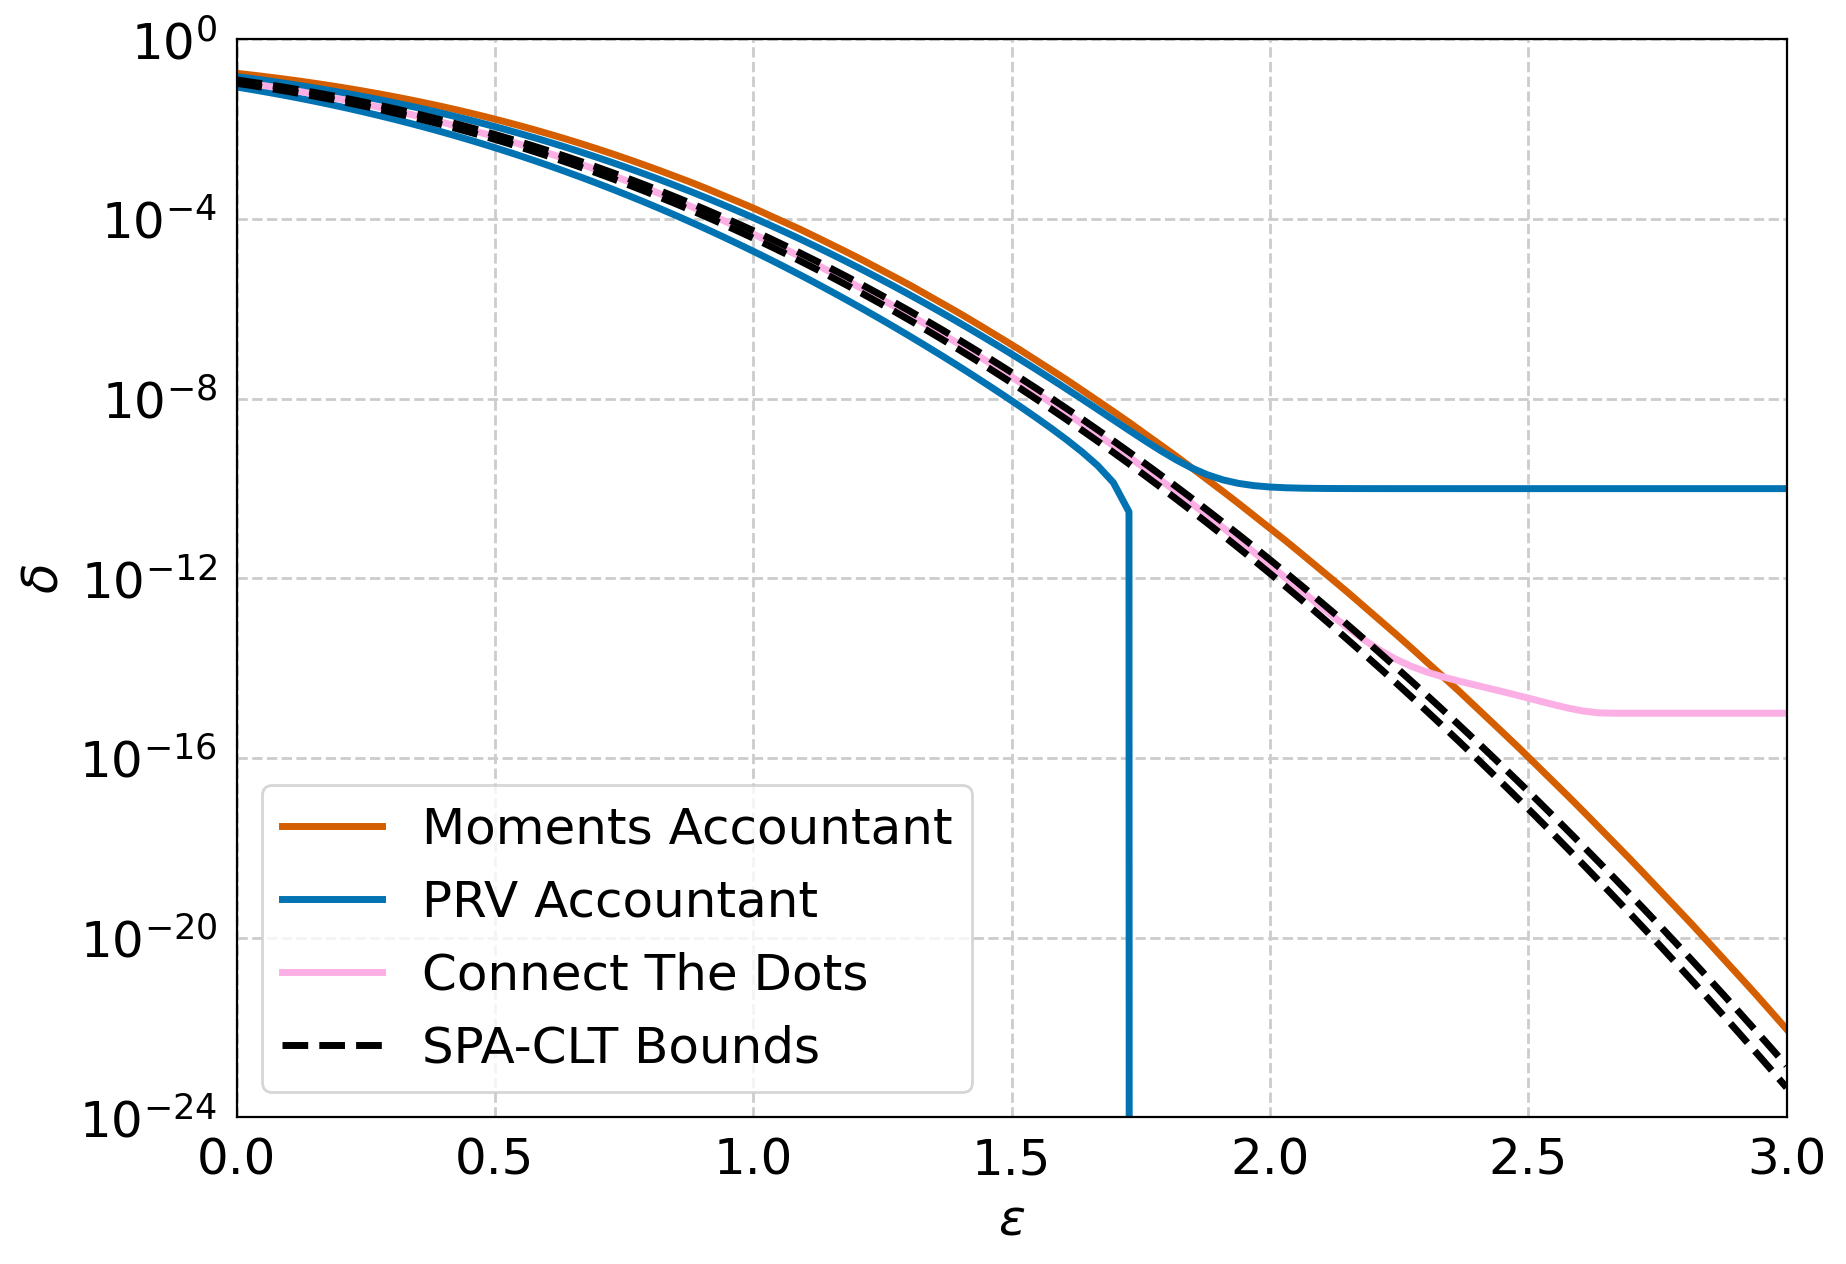

In [115]:
fig, ax = plt.subplots(figsize = (10,7), dpi = 200)

#plot results
plt.plot(eps_lst, delta_rdp,c = ma_color, linewidth=widthy, label = 'Moments Accountant')
plt.plot(eps_lst, delta_prv[:,0],c = prv_color, linewidth=widthy, label = 'PRV Accountant')
plt.plot(eps_lst, delta_prv[:,2],c = prv_color, linewidth=widthy)
plt.plot(eps_lst, delta_connect_the_dots,c = ctd_color, linewidth=widthy, label = 'Connect The Dots')
plt.plot(eps_lst, delta_clt_bounds[:,0] - delta_clt_bounds[:,1],c = 'black',linestyle='--', linewidth=widthy, label = 'SPA-CLT Bounds')
plt.plot(eps_lst, delta_clt_bounds[:,0] + delta_clt_bounds[:,1],c = 'black',linestyle='--', linewidth=widthy)

#grid
plt.rcParams["axes.edgecolor"] = "black";plt.grid(color='0.8', linestyle='--', linewidth=1)

#x and y limits and scale 
plt.yscale('log')
plt.xlim([0,3]); plt.ylim([1e-24,1e-0])

#x and y ticks
ax.set_xticks(np.linspace(0,3,7)); ax.set_yticks(10**(-np.linspace(0,24,7)))
ax.tick_params(labelsize=fonty, bottom = False, left = False)

#labels, legend, and savefig
plt.xlabel('$\epsilon$', fontsize = fonty)
plt.ylabel('$\delta$', fontsize = fonty)
plt.legend(fontsize = fonty);
#plt.savefig('waterfall1_updated.eps', format='eps', bbox_inches="tight");

##Figure 2 and 3

In [10]:
#Initialize parameters for all accountants
#Note: parameters such as sigma, sampling_prob, are the same as Figure 1

#Note: An Integration warning for low compositions for k = 3 is expected here. 
#The higher order saddlepoint approximation is stable only after a sufficiently 
#high number of compositions

comps_lst = np.linspace(1.5,4.5,32)*1000
delta = 1e-15

#Saddlepoint 
eps_msd1 = [acc_spa.compute_epsilon_msd(delta, int(comps), k = 1) for comps in comps_lst]
eps_msd2 = [acc_spa.compute_epsilon_msd(delta, int(comps), k = 2) for comps in comps_lst]
eps_msd3 = [acc_spa.compute_epsilon_msd(delta, int(comps), k = 3) for comps in comps_lst]
eps_clt = np.array([acc_spa.compute_epsilon_clt(delta, int(comps)) for comps in comps_lst])

#RDP Accountant
event = dp_event.PoissonSampledDpEvent(sampling_prob, dp_event.GaussianDpEvent(sigma))
eps_rdp = np.array([])
for comps in comps_lst: 
    acc_rdp = rdp_privacy_accountant.RdpAccountant().compose(event,int(comps))
    eps_rdp = np.append(eps_rdp, acc_rdp.get_epsilon(delta))

#GDP Accountant
eps_gdp = np.array([compute_eps_gdp(delta, comps, sampling_prob, sigma)[1] for comps in comps_lst])

/usr/local/lib/python3.10/dist-packages/saddlepoint_accountant/gaussian_mechanism.py:120: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, math.log(1-self._lambda), bounds[1], epsabs = 1e-15, epsrel = 1e-15)[0]


In [11]:
#Load the Truth Calculation
mp.mp.dps = 20
with open("saddlepoint_accountant/saddlepoint_accountant/other_accountants/mpmath_s2_q0p01_delta_1em15_n1500_4500_32.pkl","rb") as fb:
    true = pickle.load(fb)
eps_true = np.array([mp.mpf(oop) for oop in true])

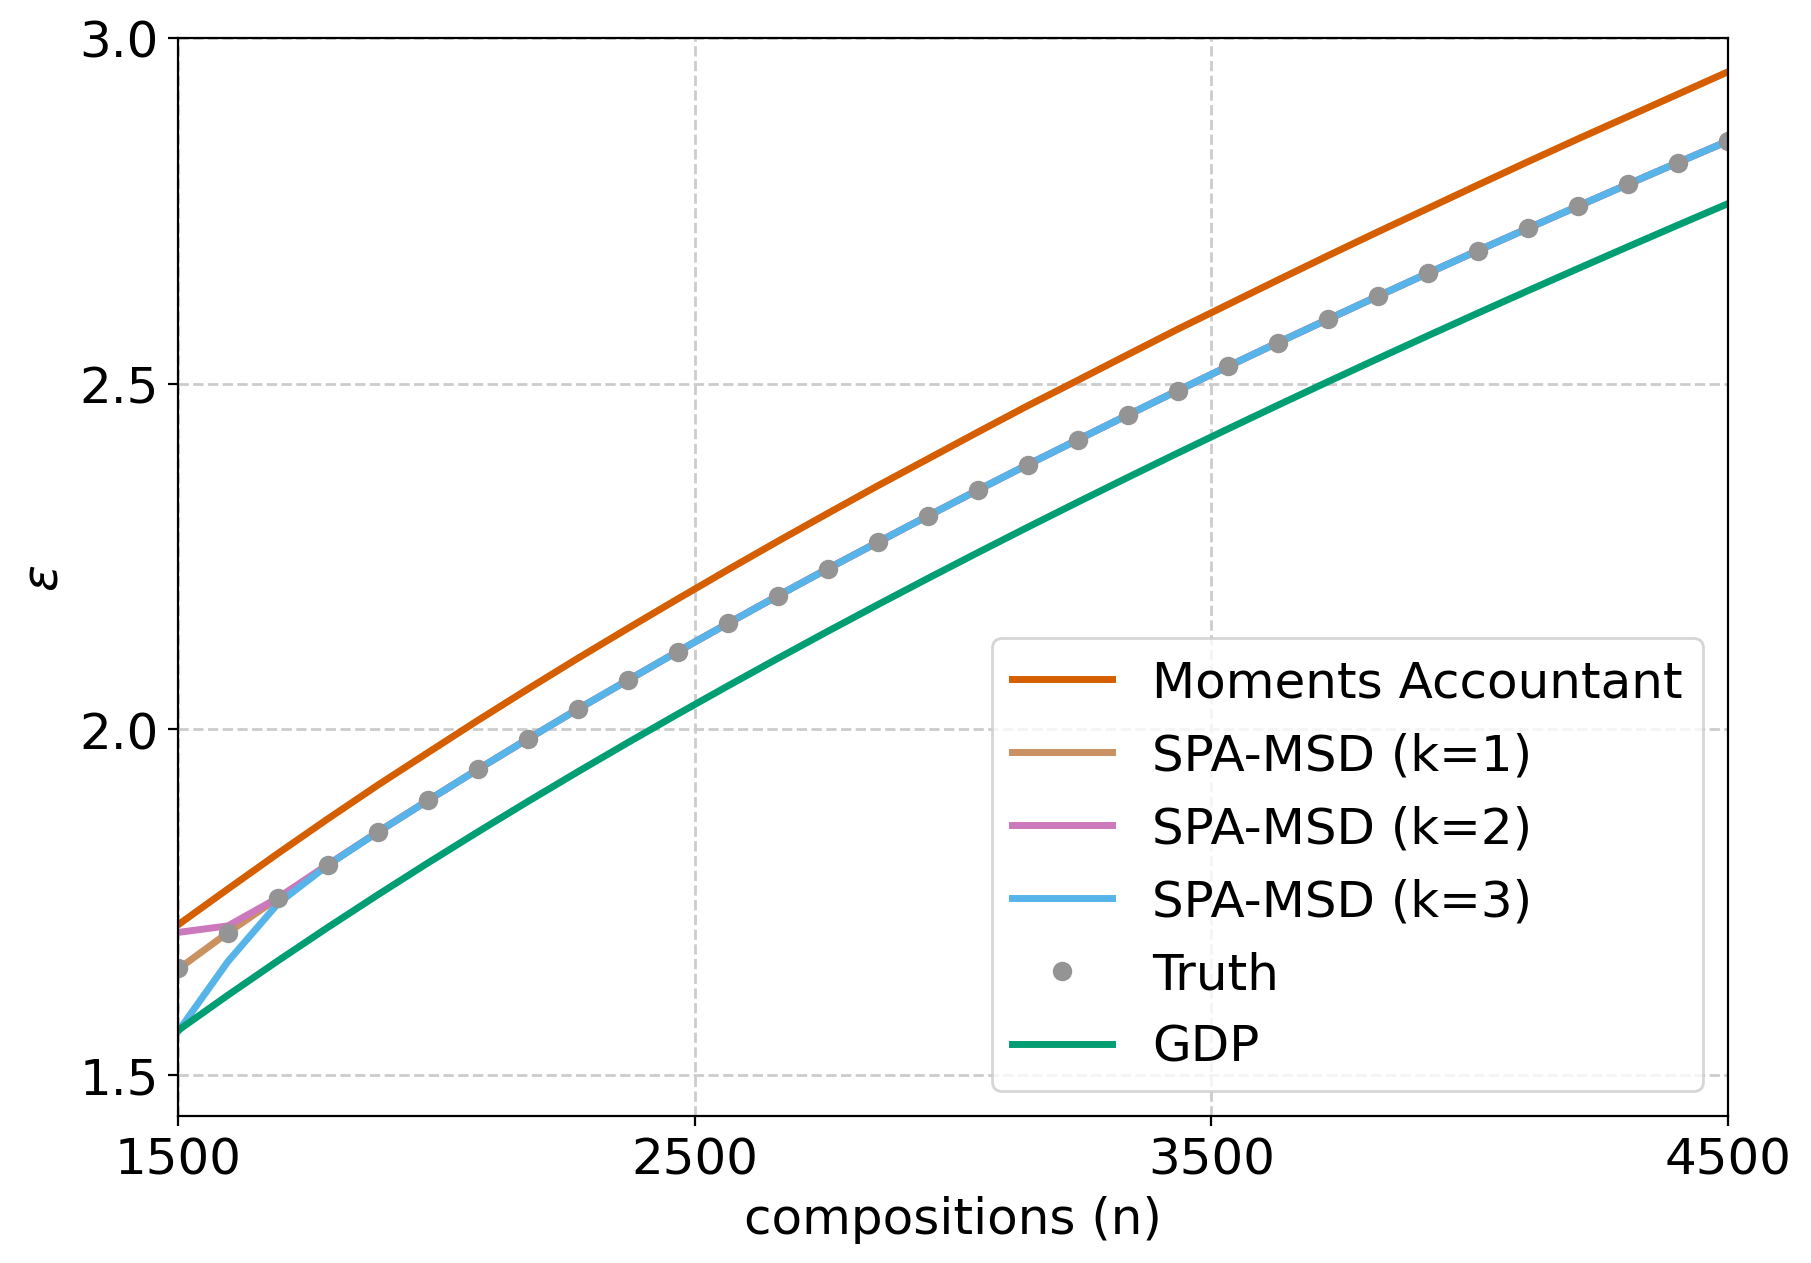

In [101]:
fig, ax = plt.subplots(dpi = 200, figsize = (10,7))

#plot results
plt.plot(comps_lst, eps_rdp, c = ma_color, label = 'Moments Accountant', linewidth=widthy)
plt.plot(comps_lst, eps_msd1, c = msd1_color, label = 'SPA-MSD (k=1)', linewidth=widthy)
plt.plot(comps_lst, eps_msd2, c =msd2_color, label = 'SPA-MSD (k=2)', linewidth=widthy)
plt.plot(comps_lst, eps_msd3, c = msd3_color, label = 'SPA-MSD (k=3)', linewidth=widthy)
plt.plot(comps_lst, eps_true,  'o',  markersize = 6, markevery=1,c = true_color, label = 'Truth', linewidth=widthy)
plt.plot(comps_lst, eps_gdp, c = gdp_color, label = 'GDP', linewidth=widthy)

#grid 
plt.rcParams["axes.edgecolor"] = "black";plt.grid(color='0.8', linestyle='--', linewidth=1)

#x and y limits
plt.xlim([comps_lst[0], comps_lst[-1]]);plt.ylim([1.44,3])

#x and y ticks
ax.set_xticks([1500,2500,3500,4500]); ax.set_yticks([1.5,2,2.5,3])
ax.tick_params(labelsize=fonty )

#labels, legend, and savefig
plt.xlabel('compositions (n)',fontsize=fonty)
plt.ylabel('$\epsilon$',fontsize=fonty)
plt.legend(loc = 'lower right', fontsize = fonty);
#plt.savefig('msd_comparisions_updated.eps', format='eps', bbox_inches="tight");

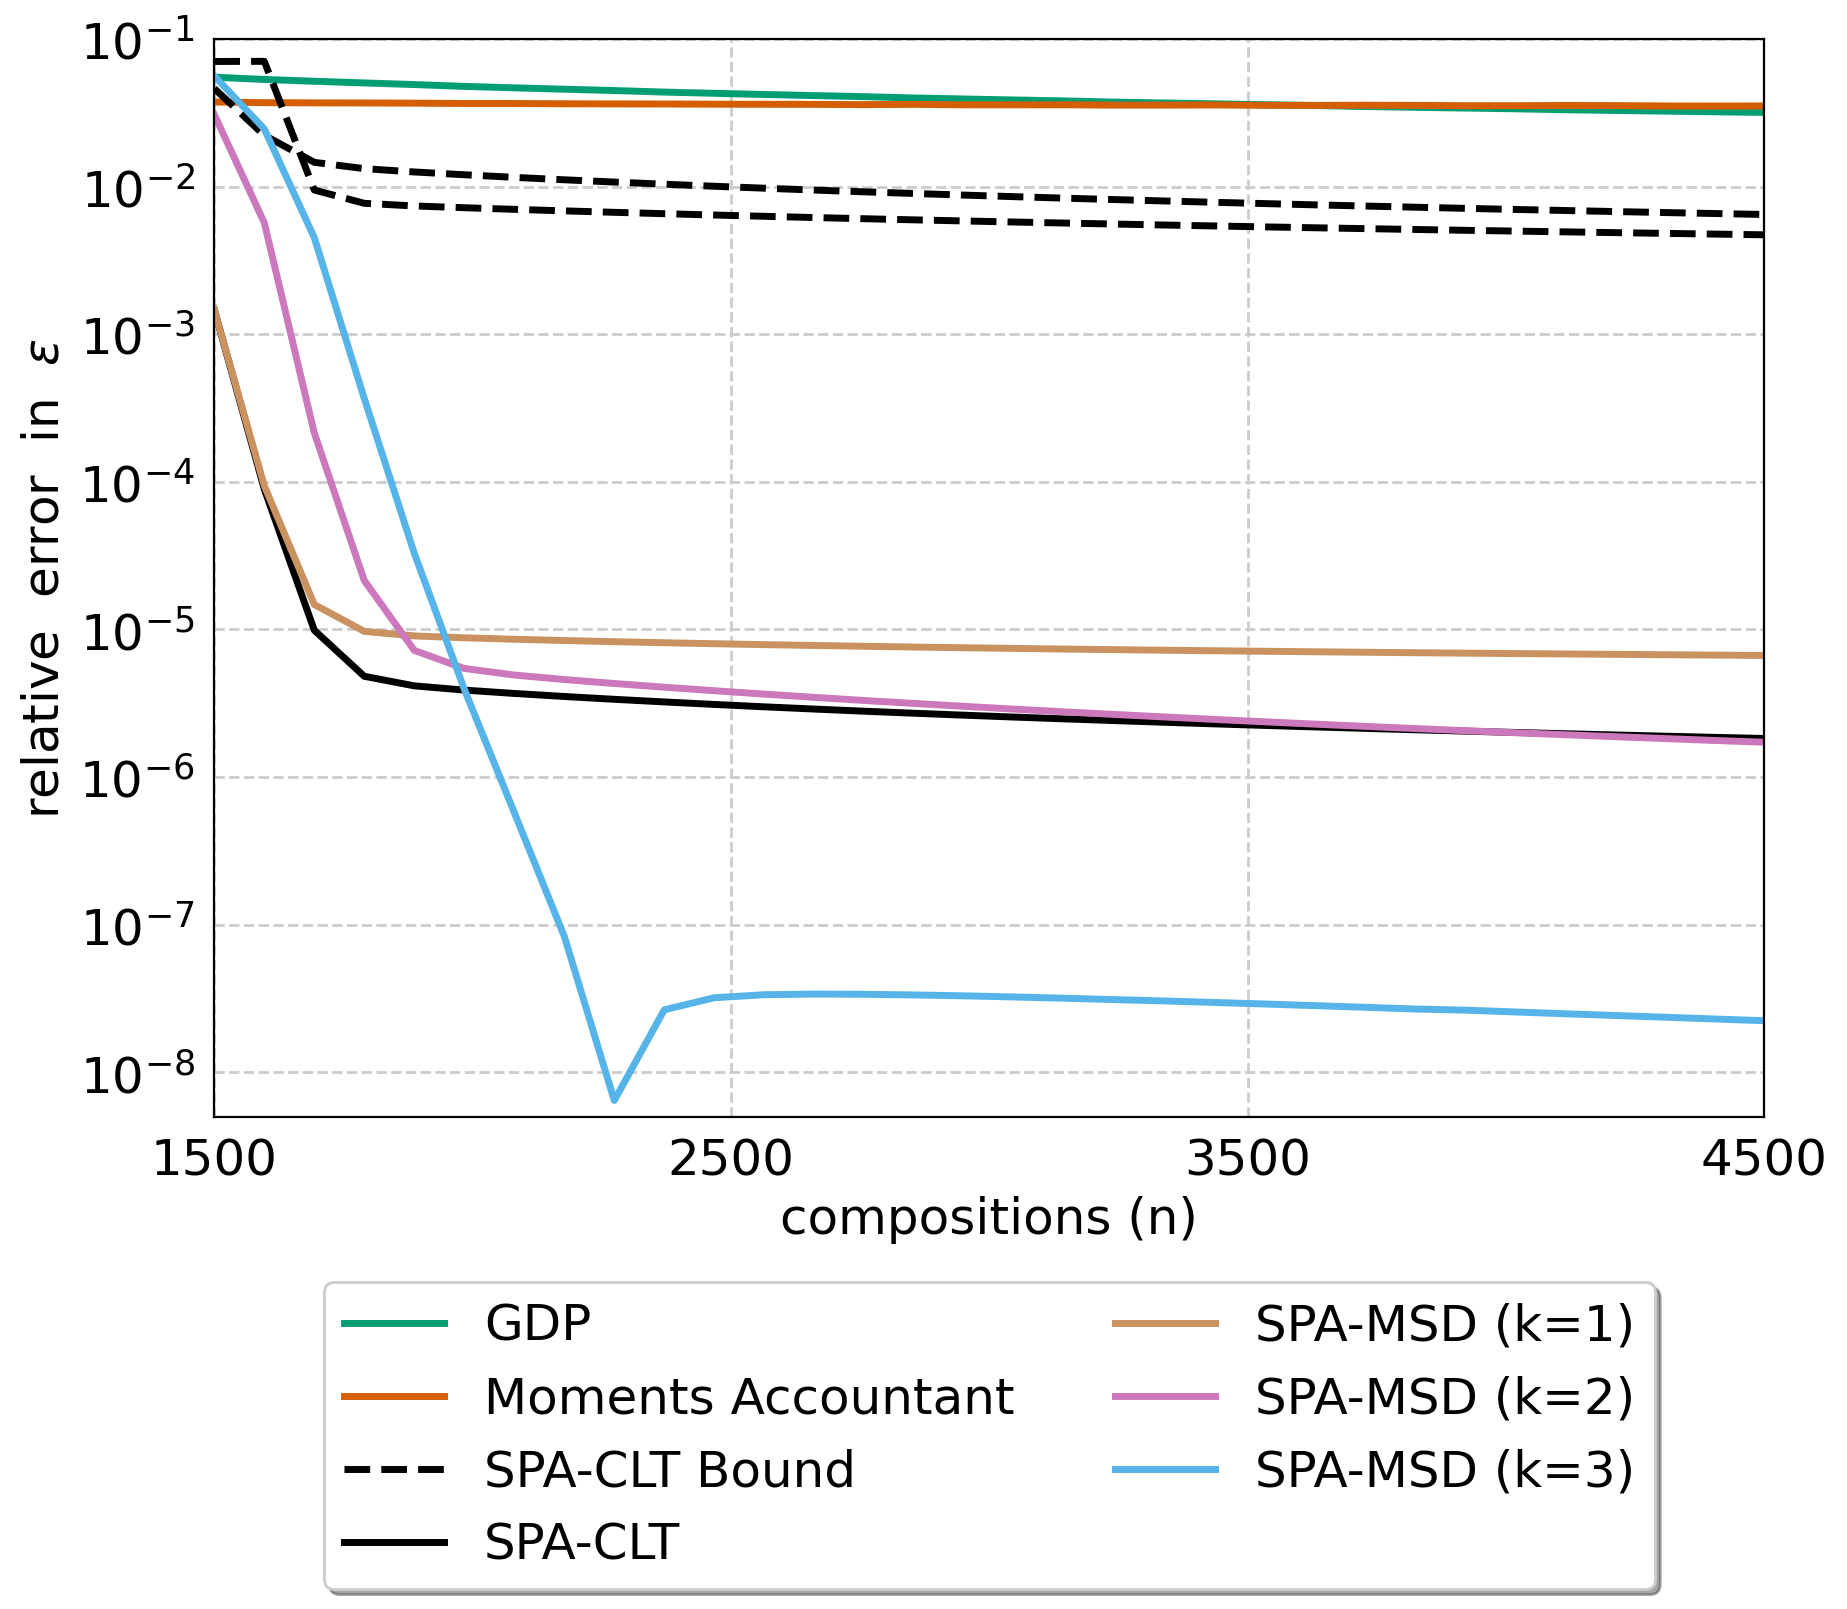

In [90]:
fig, ax = plt.subplots(dpi = 200, figsize = (10,7))

#plot results
plt.plot(comps_lst, np.abs(eps_true - eps_gdp)/eps_true, c = gdp_color, label = 'GDP', linewidth=widthy)
plt.plot(comps_lst, np.abs(eps_true - eps_rdp)/eps_true, c = ma_color, label = 'Moments Accountant', linewidth=widthy)

plt.plot(comps_lst, np.abs(eps_true - eps_clt[:,2])/eps_true, '--',c = clt_bounds_color, label = 'SPA-CLT Bound', linewidth=widthy)
plt.plot(comps_lst, np.abs(eps_true - eps_clt[:,0])/eps_true, '--',c = clt_bounds_color, linewidth=widthy)
plt.plot(comps_lst, np.abs(eps_true - eps_clt[:,1])/eps_true, c = clt_bounds_color, label = 'SPA-CLT', linewidth=widthy)


plt.plot(comps_lst, np.abs(eps_true - eps_msd1)/eps_true, c = msd1_color, label = 'SPA-MSD (k=1)', linewidth=widthy)
plt.plot(comps_lst, np.abs(eps_true - eps_msd2)/eps_true, c = msd2_color, label = 'SPA-MSD (k=2)', linewidth=widthy)
plt.plot(comps_lst, np.abs(eps_true - eps_msd3)/eps_true, c = msd3_color, label = 'SPA-MSD (k=3)', linewidth=widthy)

# grid 
plt.rcParams["axes.edgecolor"] = "black"
plt.grid(color='0.8', linestyle='--', linewidth=1)

#x and y limits and scale
plt.yscale('log')
plt.xlim([comps_lst[0], comps_lst[-1]]); plt.ylim([5e-9,1e-1])

#x and y ticks
ax.set_xticks([1500,2500,3500,4500]); ax.set_yticks(10**(-np.linspace(1,8,8)))
ax.tick_params(labelsize=fonty, which = 'both', bottom = False, left = False)

#labels, legend, and savefig
plt.xlabel('compositions (n)',fontsize=fonty)
plt.ylabel('relative  error  in  $\epsilon$',fontsize=fonty)
lgd = ax.legend(fontsize=fonty,loc = 'upper center', bbox_to_anchor=(0.5, -.13), ncol=2, fancybox=True, shadow=True);
#plt.savefig('relative_error_updated.eps',format='eps', bbox_inches="tight");